In [26]:
# ================================================================================
# Splitting training and test sets
# ================================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

data=pd.read_csv('WAGE2_2025_abridged.csv')

state=530088808+540338216+540527739+530800484+530356855 # replace this number with the sum of the student IDs for the members of your group

train = data.sample(frac=0.8, random_state=state)
test = data[data.index.isin(train.index)==False].copy() # Only for prediction

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)


print(train.shape) #Check dimensions of training data
print(test.shape) #Check dimensions of test data


#Check if there are null values 
train.isnull().any()
test.isnull().any()


#Drop null values
train=train.dropna()    
test=test.dropna()     

print(train.shape)        #Training data original: 733, after cleaning: 531, change = 202
print(test.shape)         #Test data original: 183, after cleaning: 124, change = 59

#Total change: 202 + 59 = 261

(733, 17)
(183, 17)
(531, 17)
(124, 17)


# **Task 1: Exploratory analysis**

The original data matrix contains 733 rows for training data, 183 rows for test data, and 17 columns for both. 

We realize that there are rows with null values, so our decision is to first clean the data through dropping all the rows with at least 1 null value. After cleaning, we retained 531 observations for the training data and 124 observations for the test data. 

This approach raises concerns in data loss and statistical power as after reduction only around 2/3 of the original data remain (total 655 rows). Nevertheless, through this method, we aim to keep data reliability, avoid introducing bias or analysis errors, and avoid false assumptions. We believe that the 655 remaining data points can provide reasonable information for meaningful analysis. 

In [27]:
# Check the first 5 rows of data 
train.head()
test.head()

wage  hours   IQ  KWW  educ  exper  tenure  age  married  black  south  \
1   1318     38  119   24    16      7       2   28        1      0      0   
2   1792     40  118   47    16      9       9   34        1      0      0   
7   1274     40  106   35    13     11      12   31        1      0      0   
8    692     40  108   48    12     21      11   38        1      0      0   
10   808     60  109   47    13     14      12   38        1      0      0   

    urban  sibs  brthord  meduc  feduc     lwage  
1       1     3      1.0   10.0   10.0  7.183871  
2       1     1      1.0   12.0   12.0  7.491087  
7       1     0      1.0   15.0   12.0  7.149917  
8       1     3      1.0    8.0    7.0  6.539586  
10      1     2      2.0   12.0   10.0  6.694562

In [28]:
# EDA after cleaning
train.describe().round(2)
test.describe().round(2)

wage   hours      IQ     KWW    educ   exper  tenure     age  \
count   124.00  124.00  124.00  124.00  124.00  124.00  124.00  124.00   
mean    957.16   44.08  100.48   35.73   13.55   11.23    7.94   32.84   
std     401.36    6.83   14.22    7.55    2.16    4.23    5.15    2.89   
min     200.00   32.00   66.00   19.00    9.00    1.00    0.00   28.00   
25%     687.25   40.00   91.00   30.00   12.00    8.00    3.00   30.00   
50%     943.50   40.00   99.50   36.50   12.00   11.00    8.00   32.50   
75%    1154.25   48.00  109.25   41.00   16.00   14.25   12.00   35.00   
max    2771.00   70.00  134.00   49.00   18.00   21.00   20.00   38.00   

       married   black   south   urban    sibs  brthord   meduc   feduc  \
count   124.00  124.00  124.00  124.00  124.00   124.00  124.00  124.00   
mean      0.90    0.09    0.27    0.70    2.69     2.02   10.54   10.26   
std       0.31    0.29    0.44    0.46    2.08     1.29    2.94    3.25   
min       0.00    0.00    0.00    0.00    0.00     1.00    1.00    3.00   
25%       1.00    0.00    0.00    0.00    1.00     1.00    8.00    8.00   
50%       1.00    0.00    0.00    1.00    2.00     2.00   12.00   10.00   
75%       1.00    0.00    1.00    1.00    3.00     2.00   12.00   12.00   
max       1.00    1.00    1.00    1.00   13.00     7.00   18.00   18.00   

        lwage  
count  124.00  
mean     6.78  
std      0.43  
min      5.30  
25%      6.53  
50%      6.85  
75%      7.05  
max      7.93

### **a. Distribution of numerical variables vs wage**

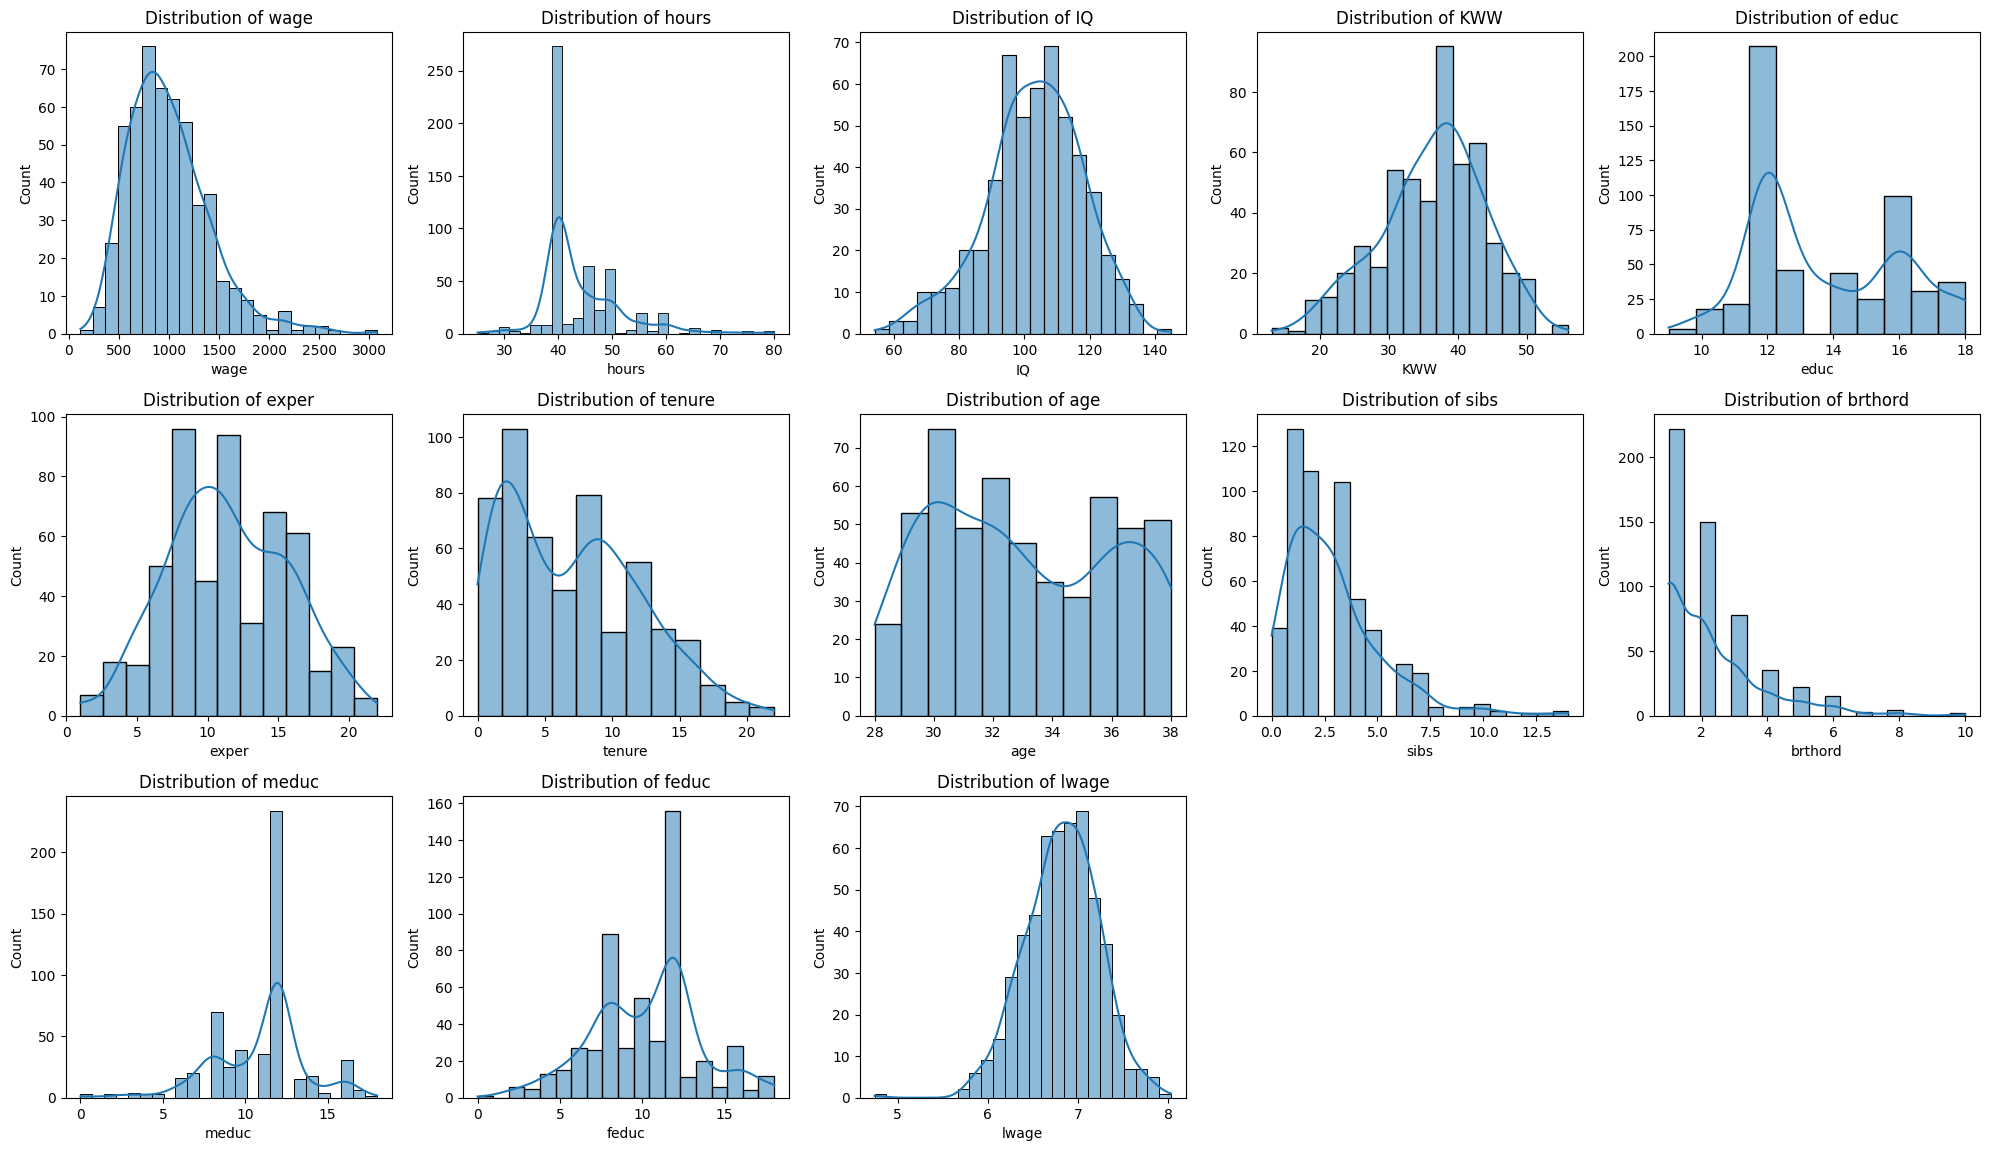

In [29]:
#Distribution of numerical variables
variables = ['wage','hours','IQ', 'KWW', 'educ', 'exper', 'tenure','age','sibs','brthord','meduc','feduc','lwage']
n_cols=5
n_rows=4
fig,axes=plt.subplots(n_rows,n_cols,figsize=(20,15))
axes=axes.flatten()
for i, var in enumerate(variables):
    sns.histplot(train[var],kde=True,ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
for j in range (i+1,len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

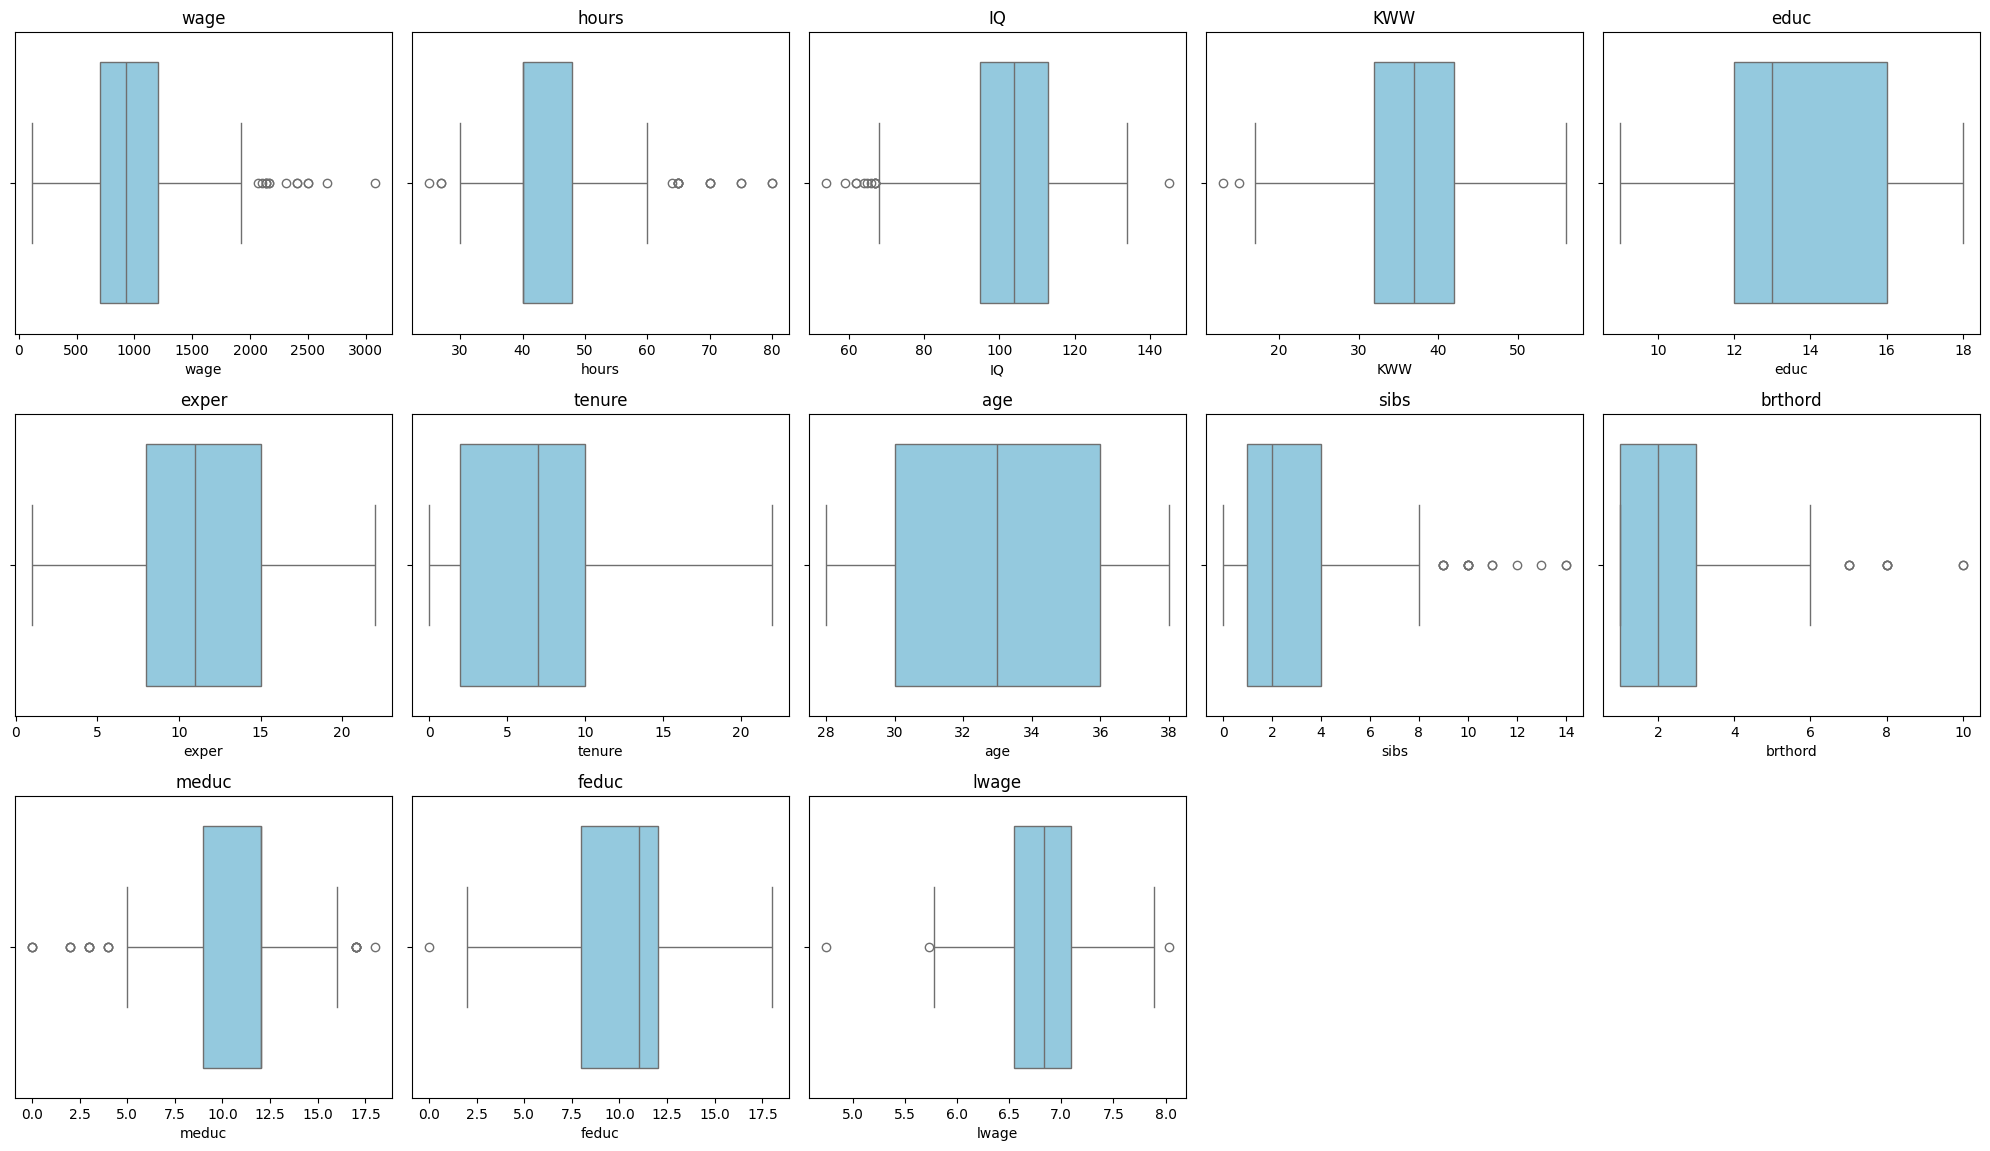

In [30]:
#boxplots of numerical variables
variables = ['wage','hours','IQ', 'KWW', 'educ', 'exper', 'tenure','age','sibs','brthord','meduc','feduc','lwage']
n_cols=5
n_rows=4
fig,axes=plt.subplots(n_rows,n_cols,figsize=(20,15))
axes=axes.flatten()
for i, var in enumerate(variables):
    sns.boxplot(x=train[var],ax=axes[i],color='skyblue')
    axes[i].set_title(f'{var}')
    axes[i].set_ylabel('')
for j in range (i+1,len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

The distribution of wage is skewed heavily to the right, indicating that most individuals earn around the lower range, and a few high-earners that push the tail.

In both sets of graphs, IQ, KWW, exper, educ, and lwage seem to be approximately normally distributed. This suggests that they could be used for future modelling stages, but assumptions remain unchecked and visual interpretation might not be completely correct. 

The variable lwage (log of wage) follows somewhat a normal distribution; therefore we can consider this for transformation effects in future stages. 

### **b. Distribution of categorical variables vs wage**

In [31]:
#side-by-side boxplots of wages vs categorical variabes
fig,ax=plt.subplots(2,2,figsize=(20,22))
sns.boxplot(x=train['married'],y=train['wage'],hue=train['married'],palette=['skyblue','orange'],ax=ax[0,0],showmeans=True)
ax[0,0].set_title('Wage vs Marrital status')
ax[0,0].set_xlabel('Marrital status')
ax[0,0].set_ylabel('Wage')
ax[0,0].set_xticks([0,1],['Not married','Married'])
sns.boxplot(x=train['urban'],y=train['wage'],hue=train['urban'],palette=['skyblue','orange'],ax=ax[0,1],showmeans=True)
ax[0,1].set_title('Wage vs Living area')
ax[0,1].set_xlabel('Living area')
ax[0,1].set_ylabel('Wage')
ax[0,1].set_xticks([0,1],['Not SMSA','SMSA'])
sns.boxplot(x=train['black'],y=train['wage'],hue=train['black'],palette=['skyblue','orange'],ax=ax[1,0],showmeans=True)
ax[1,0].set_title('Wage vs Race')
ax[1,0].set_xlabel('Race')
ax[1,0].set_ylabel('Wage')
ax[1,0].set_xticks([0,1],['Non-black','Black'])
sns.boxplot(x=train['south'],y=train['wage'],hue=train['south'],palette=['skyblue','orange'],ax=ax[1,1],showmeans=True)
ax[1,1].set_title('Wage vs State')
ax[1,1].set_xlabel('State')
ax[1,1].set_ylabel('Wage')
ax[1,1].set_xticks([0,1],['Not South','South'])
plt.show()

- Holding all else constant, married people have a higher median of wage than those who are not. Looking at the graph we can see that the box plot for married people have more outliers, which can cause skewness to higher values of wage. However, this distribution may suggest mild positive effects of marital status to monthly earnings. 

- Holding all else constant, people living in the SMSA have higher overall wages than those who are outside. the spread is also higher, indicating that people living in SMSA have higher wages overall. 

- Holding all else constant, black people have visibly lower wages than non-black people. They have lower median wage, as well as no outliers.

- Holding all else constant, people living in the South seem to have lower median wage than non-southern people, but overall not too much difference.

### **c. Correlation matrix of all variables**

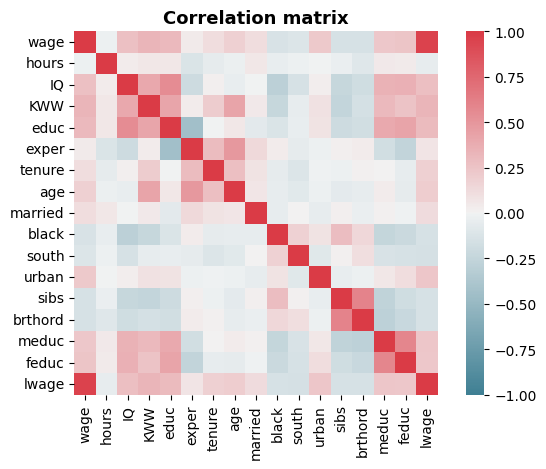

In [32]:
fig,ax=plt.subplots()
variables=['wage','hours','IQ', 'KWW', 'educ', 'exper', 'tenure','age','married','black','south','urban','sibs','brthord','meduc','feduc','lwage']
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train[variables].corr(), vmax=1, vmin=-1, center=0, square=True, ax=ax, cmap=cmap)
ax.set_title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

The correlation heat-map illustrates some strong positive and negative correlations between variables in this dataset. 
- Positive correlations with the response variable wage exist for IQ, KWW, educ, urban. Age, meduc, feduc, and urban also appear to be positively correlated with wage. The strongest positive correlation is with lwage, which is understandable as lwage is natural log of wage. 

- Surprisingly, exper (years of experience) seems to have little to none correlation with wage, while black and south are negatively correlated, aligning with the distribution graphs above.



In [33]:
train[variables].corr().round(2)

wage  hours    IQ   KWW  educ  exper  tenure   age  married  black  \
wage     1.00  -0.02  0.27  0.33  0.31   0.04    0.12  0.18     0.11  -0.14   
hours   -0.02   1.00  0.04  0.06  0.06  -0.12   -0.06 -0.03     0.06  -0.04   
IQ       0.27   0.04  1.00  0.40  0.55  -0.20    0.02 -0.04    -0.01  -0.29   
KWW      0.33   0.06  0.40  1.00  0.42   0.03    0.20  0.42     0.05  -0.24   
educ     0.31   0.06  0.55  0.42  1.00  -0.44   -0.00  0.05    -0.07  -0.12   
exper    0.04  -0.12 -0.20  0.03 -0.44   1.00    0.29  0.49     0.13   0.03   
tenure   0.12  -0.06  0.02  0.20 -0.00   0.29    1.00  0.27     0.08  -0.06   
age      0.18  -0.03 -0.04  0.42  0.05   0.49    0.27  1.00     0.07  -0.05   
married  0.11   0.06 -0.01  0.05 -0.07   0.13    0.08  0.07     1.00  -0.05   
black   -0.14  -0.04 -0.29 -0.24 -0.12   0.03   -0.06 -0.05    -0.05   1.00   
south   -0.11  -0.02 -0.14 -0.05 -0.04  -0.06   -0.11 -0.08     0.00   0.18   
urban    0.22  -0.00  0.03  0.09  0.08  -0.02   -0.01 -0.02    -0.05   0.08   
sibs    -0.15  -0.03 -0.24 -0.25 -0.20   0.02   -0.02 -0.07     0.02   0.28   
brthord -0.14  -0.10 -0.18 -0.16 -0.18   0.04    0.02 -0.05    -0.04   0.15   
meduc    0.23   0.05  0.35  0.31  0.39  -0.18    0.00  0.04     0.01  -0.24   
feduc    0.25   0.04  0.36  0.26  0.42  -0.26   -0.05 -0.06    -0.01  -0.21   
lwage    0.96  -0.05  0.28  0.33  0.30   0.07    0.18  0.20     0.12  -0.15   

         south  urban  sibs  brthord  meduc  feduc  lwage  
wage     -0.11   0.22 -0.15    -0.14   0.23   0.25   0.96  
hours    -0.02  -0.00 -0.03    -0.10   0.05   0.04  -0.05  
IQ       -0.14   0.03 -0.24    -0.18   0.35   0.36   0.28  
KWW      -0.05   0.09 -0.25    -0.16   0.31   0.26   0.33  
educ     -0.04   0.08 -0.20    -0.18   0.39   0.42   0.30  
exper    -0.06  -0.02  0.02     0.04  -0.18  -0.26   0.07  
tenure   -0.11  -0.01 -0.02     0.02   0.00  -0.05   0.18  
age      -0.08  -0.02 -0.07    -0.05   0.04  -0.06   0.20  
married   0.00  -0.05  0.02    -0.04   0.01  -0.01   0.12  
black     0.18   0.08  0.28     0.15  -0.24  -0.21  -0.15  
south     1.00  -0.09  0.01     0.11  -0.14  -0.14  -0.15  
urban    -0.09   1.00 -0.05    -0.02   0.06   0.11   0.24  
sibs      0.01  -0.05  1.00     0.60  -0.27  -0.18  -0.14  
brthord   0.11  -0.02  0.60     1.00  -0.28  -0.22  -0.15  
meduc    -0.14   0.06 -0.27    -0.28   1.00   0.58   0.24  
feduc    -0.14   0.11 -0.18    -0.22   0.58   1.00   0.23  
lwage    -0.15   0.24 -0.14    -0.15   0.24   0.23   1.00

### **d. Scatter plots of all combinations of variables**

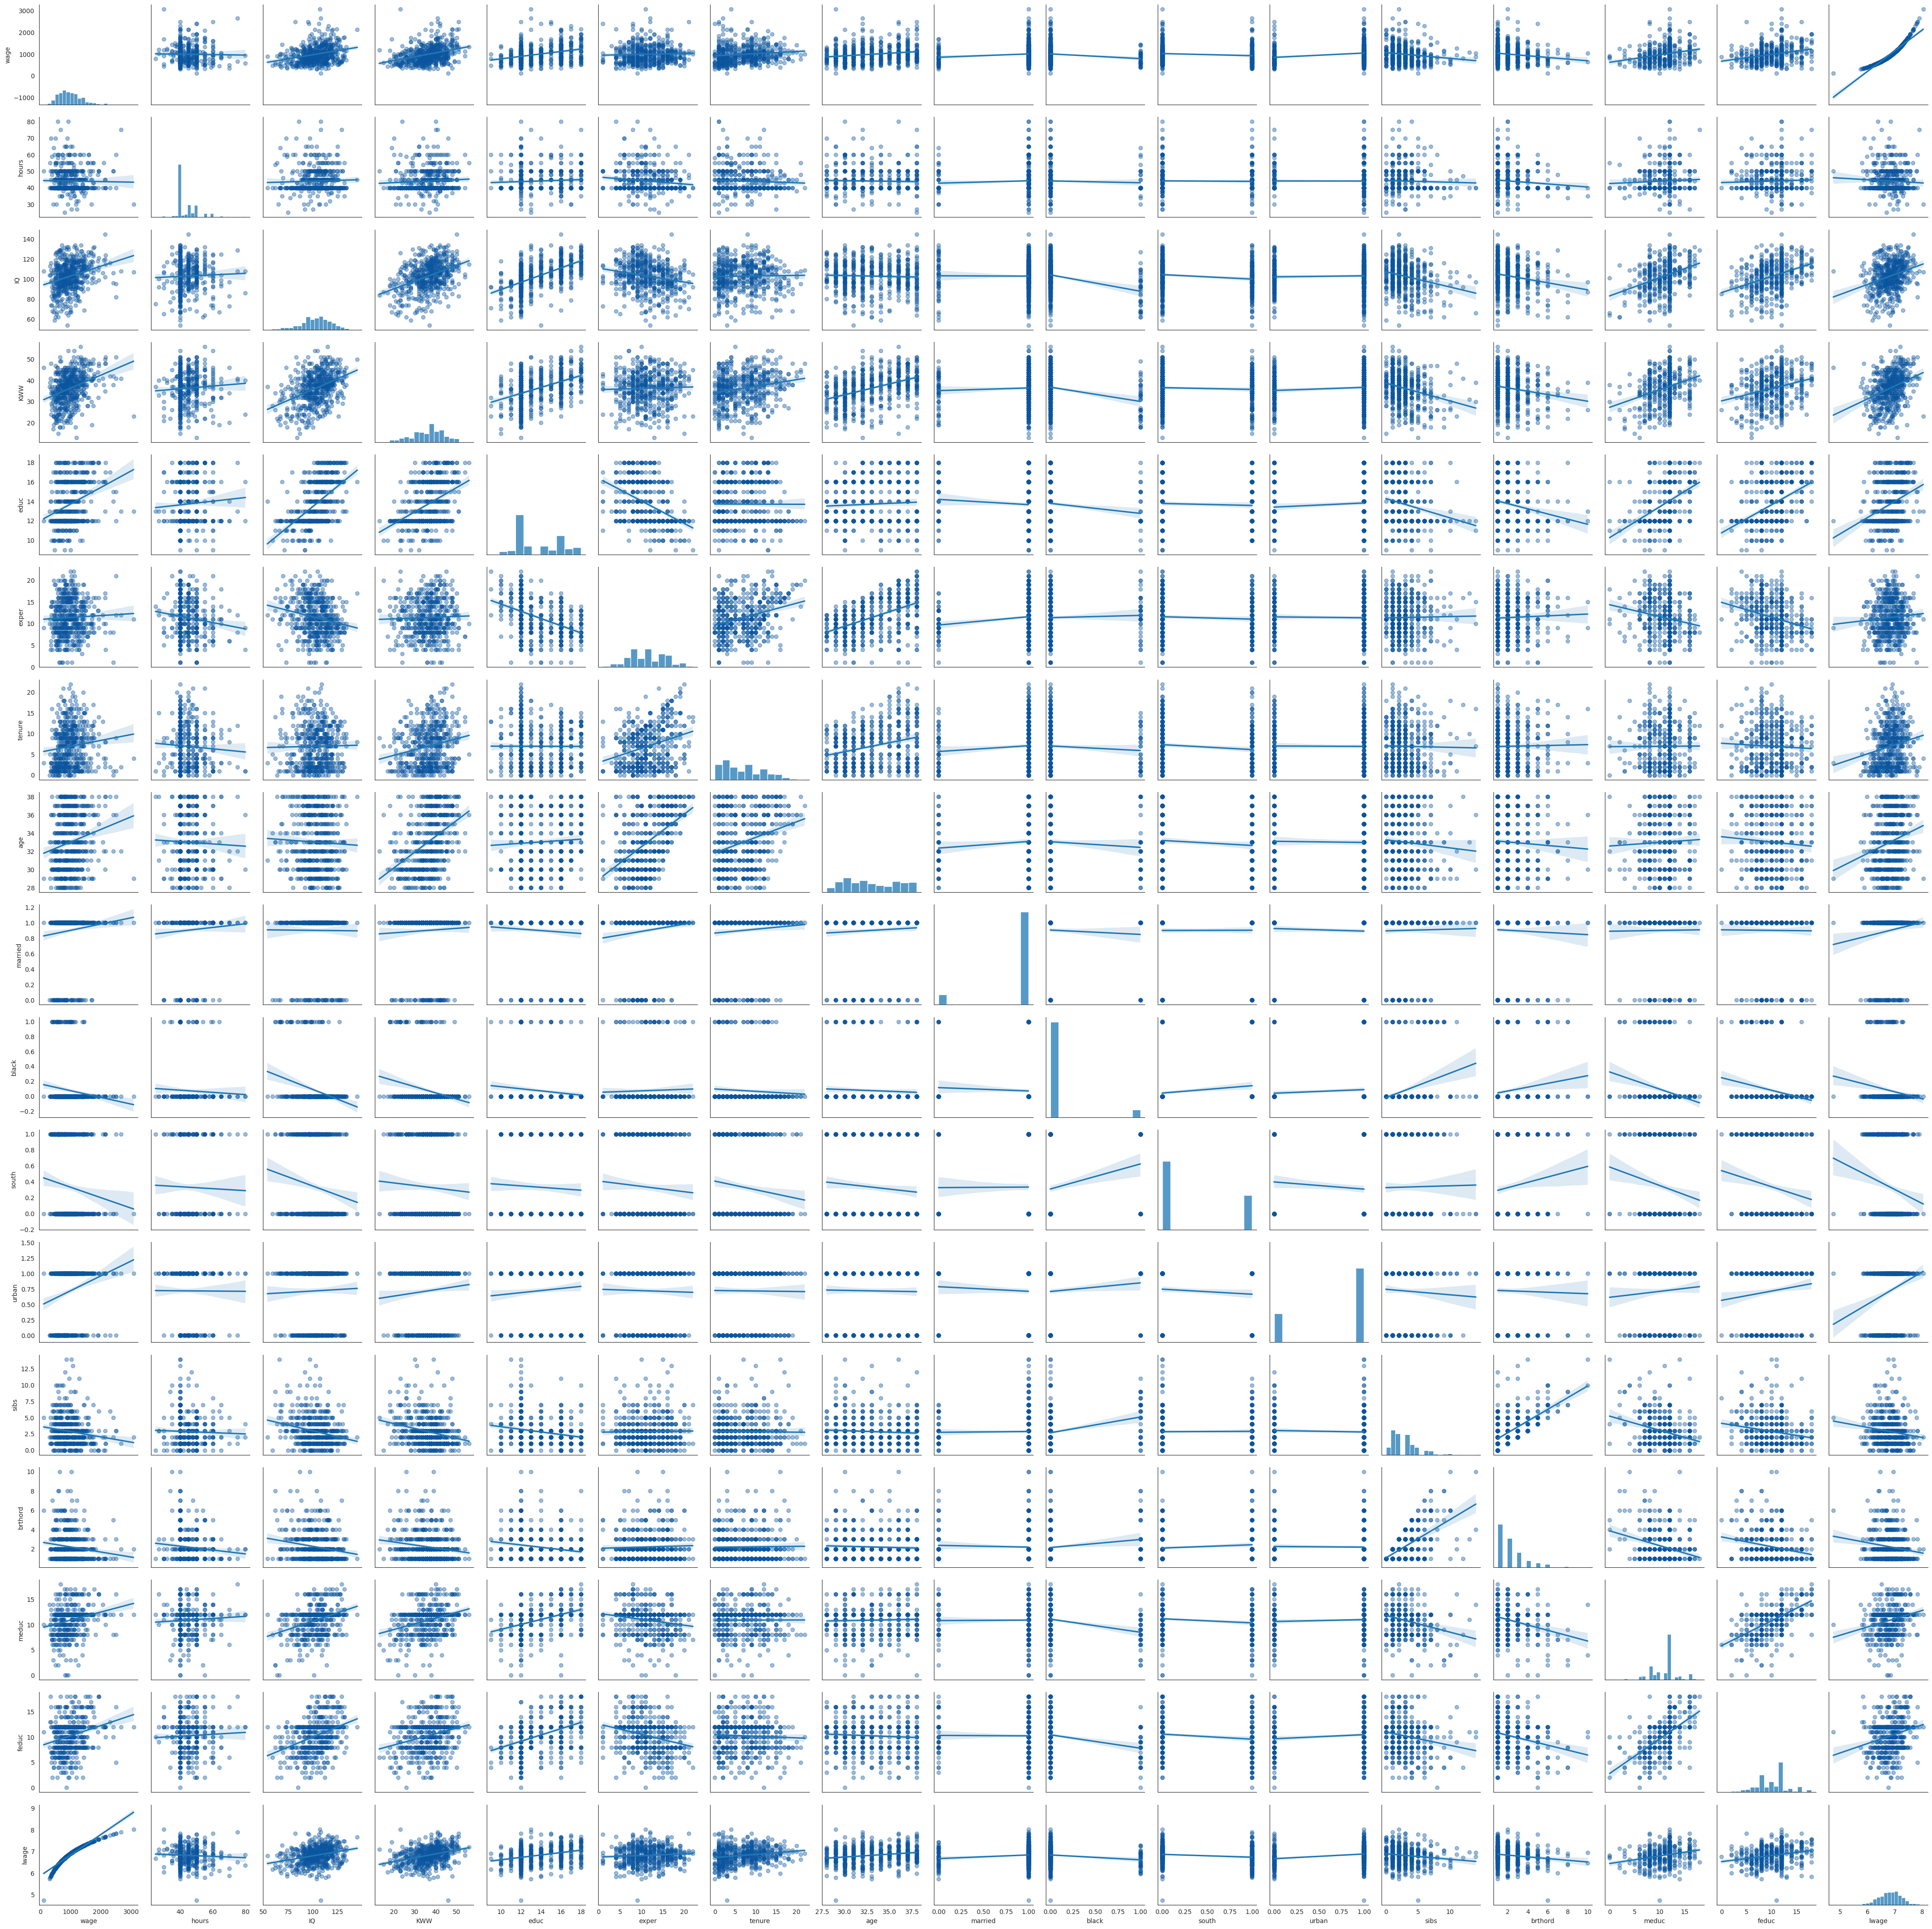

In [34]:
with sns.axes_style('white'):
    g=sns.pairplot(train[variables], kind='reg',
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})
plt.tight_layout()
g.savefig('DM-pairplot.png', dpi=300)
plt.show()

Clear positive relationships exist between wage and variables such as IQ, KWW, and education. These relationships appear approximately linear and relatively strong, suggesting these variables may be important predictors in modeling wage. For example, as education increases, average wages also tend to rise, which aligns with economic expectations.

However, some relationships are more complex. The relationship between wage and experience (exper) is initially positive but flattens or even dips slightly at higher levels, indicating a potential non-linear trend. This is also reflected in the plot with tenure and age, where the pattern is less clearly linear and may warrant modeling with squared or interaction terms.

Several categorical variables such as married, black, south, and urban show distinct groupings in wage but with overlapping distributions, implying they may influence wage through interaction effects or differ in variance, rather than in pure mean differences.

Regarding the parental education variables (meduc and feduc), the relationships with wage are present but weak. This suggests background factors may have some influence, though they are not as predictive as an individual's own education or ability (as proxied by IQ and KWW).

In terms of relationships between the predictors, no extremely strong correlations are observed that would suggest problematic multicollinearity. While there are some moderate associations (e.g., between educ and IQ, or tenure and age), none are strong enough to cause immediate concern for variance inflation in the regression model. At this stage, multicollinearity does not appear to be a major issue.

# **Task 2: Analysis of relationship between exper, educ, and wage**

### **a. Data description**

In [35]:
train[['wage','educ','exper']].describe().round(2)  #training data description

wage    educ   exper
count   531.00  531.00  531.00
mean    995.62   13.73   11.41
std     409.45    2.25    4.26
min     115.00    9.00    1.00
25%     700.00   12.00    8.00
50%     929.00   13.00   11.00
75%    1201.50   16.00   15.00
max    3078.00   18.00   22.00

### **b. Multiple Linear Regression (MLR)**

In [36]:
#Full model MLR (numerical + categorical)

model = smf.ols(formula='wage ~ hours +  IQ + KWW + educ + exper + tenure + age + married + black + south + urban + sibs + brthord + meduc + feduc', data=train)
reg = model.fit()
reg.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     10.70
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.22e-22
Time:                        17:33:02   Log-Likelihood:                -3874.8
No. Observations:                 531   AIC:                             7782.
Df Residuals:                     515   BIC:                             7850.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -594.3412    260.485     -2.282      0.023   -1106.085     -82.597
hours         -2.2238      2.215     -1.004      0.316      -6.576       2.128
IQ             1.9545      1.405      1.391      0.165      -0.807       4.716
KWW            6.6200      2.785      2.377      0.018       1.149      12.091
educ          37.9593     10.413      3.646      0.000      17.503      58.416
exper         12.1049      5.264      2.300      0.022       1.763      22.447
tenure         2.5618      3.434      0.746      0.456      -4.185       9.308
age            5.9827      6.944      0.862      0.389      -7.659      19.625
married      146.8417     54.020      2.718      0.007      40.716     252.968
black        -67.0372     66.932     -1.002      0.317    -198.531      64.457
south        -27.3144     35.273     -0.774      0.439     -96.611      41.982
urban        170.7131     36.030      4.738      0.000      99.929     241.497
sibs           1.5727      9.227      0.170      0.865     -16.555      19.700
brthord      -11.2680     13.480     -0.836      0.404     -37.750      15.214
meduc          3.2926      7.307      0.451      0.652     -11.062      17.648
feduc         11.1663      6.228      1.793      0.074      -1.070      23.402
==============================================================================
Omnibus:                      164.611   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              630.335
Skew:                           1.378   Prob(JB):                    1.33e-137
Kurtosis:                       7.571   Cond. No.                     2.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The effects of each variable can be summarized as:

Keeping all other variables constant, an increase of 1 average weekly hour is associated with an average decrease in the wage of 2.22 dollars.

Keeping all other variables constant, an increase of 1 IQ score is associated with an average increase in the wage of 1.95 dollars.

Keeping all other variables constant, an increase of 1 knowledge of world work score is associated with an average increase in the wage of 6.62 dollars.

Keeping all other variables constant, an increase of 1 year of education is associated with an average increase in the wage of 37.96 dollars.

Keeping all other variables constant, an increase of 1 year of experience is associated with an average increase in the wage of 12.10 dollars.

Keeping all other variables constant, an increase of 1 year with current employer is associated with an average decrease in the wage of 2.56 dollars.

Keeping all other variables constant, an increase of 1 age is associated with an average increase in the wage of 5.98 dollars.

Keeping all other variables constant, married people earns 146.84 dollars on average more than others. 

Keeping all other variables constant, black people earns 67.04 dollars on average less than others. 

Keeping all other variables constant, south people earns 27.31 dollars on average less than others. 

Keeping all other variables constant, urban people earns 170.71 dollars on average more than others. 

Keeping all other variables constant, an increase of 1 sibling is associated with an average increase in the wage of 1.57 dollars.

Keeping all other variables constant, an increase of 1 birth order is associated with an average decrease in the wage of 11.27 dollars.

Keeping all other variables constant, an increase of 1 year of mother's education is associated with an average increase in the wage of 3.29 dollars.

Keeping all other variables constant, an increase of 1 year of father's education is associated with an average increase in the wage of 11.17 dollars.


In [37]:
reg.mse_resid**0.5

np.float64(362.69230272797444)

In [38]:
#Full model MLR (numerical only)

model = smf.ols(formula='wage ~ hours +  IQ + KWW + educ + exper + tenure + age + sibs + brthord + meduc + feduc', data=train)
reg = model.fit()
reg.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     11.22
Date:                Wed, 14 May 2025   Prob (F-statistic):           8.69e-19
Time:                        17:33:02   Log-Likelihood:                -3890.2
No. Observations:                 531   AIC:                             7804.
Df Residuals:                     519   BIC:                             7856.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -433.6795    255.942     -1.694      0.091    -936.488      69.129
hours         -1.8101      2.265     -0.799      0.425      -6.260       2.640
IQ             2.0560      1.402      1.466      0.143      -0.699       4.811
KWW            8.0310      2.823      2.845      0.005       2.485      13.577
educ          37.5400     10.548      3.559      0.000      16.819      58.261
exper         14.3972      5.364      2.684      0.008       3.859      24.935
tenure         3.0966      3.498      0.885      0.376      -3.775       9.968
age            4.1275      7.083      0.583      0.560      -9.787      18.042
sibs           0.6802      9.176      0.074      0.941     -17.347      18.708
brthord      -12.2056     13.679     -0.892      0.373     -39.079      14.668
meduc          4.0213      7.455      0.539      0.590     -10.625      18.668
feduc         14.5355      6.332      2.295      0.022       2.095      26.976
==============================================================================
Omnibus:                      151.318   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              526.871
Skew:                           1.294   Prob(JB):                    3.90e-115
Kurtosis:                       7.138   Cond. No.                     1.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
#Reduced model (educ + exper)

model_base = smf.ols(formula='wage ~ educ + exper', data=train) 
regbase = model_base.fit()
regbase.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     41.43
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.93e-17
Time:                        17:33:02   Log-Likelihood:                -3908.1
No. Observations:                 531   AIC:                             7822.
Df Residuals:                     528   BIC:                             7835.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -264.3942    142.291     -1.858      0.064    -543.921      15.133
educ          74.1534      8.201      9.042      0.000      58.043      90.263
exper         21.2275      4.323      4.910      0.000      12.735      29.720
==============================================================================
Omnibus:                      135.138   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.743
Skew:                           1.220   Prob(JB):                     2.34e-85
Kurtosis:                       6.416   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Similar to the full model, both variables educ and exper are positively related to wage. The effects of each variable can be summarized as:

- Keeping years of work experience constant, an increase of 1 year of education is associated with an average increase in the wage of 74.15 dollars.
- Keeping years of education constant, an increase of 1 year of experience is associated with an average increase in the wage of 21.23 dollars.

Noteworthily, the estimated coefficients for educ and exper in the reduced model are significantly different to their respective etimates in the full model (nearly twice the full model's estimation). This could be evidence of some omitted variable bias (OVB) in this reduced model, for both variables. We consider this in more detail in Task 3. 


In [40]:
residbase=regbase.resid
fitbase=regbase.fittedvalues
regbase.mse_resid**0.5

np.float64(381.38333895467906)

In [41]:
train[['educ','exper']].corr()

educ     exper
educ   1.000000 -0.438547
exper -0.438547  1.000000

In [42]:
1/(1-(-0.438547**2))

0.8386985781517942

### **c. Measure of fit (reduced model)**

- The full model has $R^2$ = 0.238$, $R^2_{adj}$ = 0.215$ and SER = $362.69$ dollars. This means that it captures about $19\%$ of the variation in wages, with a typical prediction error of about $\$363$.
- The reduced model has $R^2 = 0.136$, $R^2_{adj} = 0.132$ and SER = $375.64$ dollars. This means that it captures about $14\%$ of the variation in wages, with a typical prediction error of about $\$376$. 

Both models are relatively weak fits to the data, but the full model is the strongest fit between the two, capturing about $10$ percentage point more variation in wages and reducing the prediction error by about $\$13$.   

The low values for $R^2$ and $R^2_{adj}$ can mainly be due to weak predictors overall of the model (intuitively sibs, brthord, etc. may have have little real impact on wage) and non-linearity of some of the variables. Therefore, other meaningful predictors should rather be used, and transformations will be further examined in Task 3 and 4. Another concern is with the amount of data we have dropped in the data cleaning process: up to 1/3 of original data. This may cause significant reduction in $R^2$ and $R^2{adj}$. 

The variance inflation can be measured by the $R^2$ in the regression of one regressor on the other. Both equal to $\frac{1}{1-r^2}$, where $r$ is the correlation between educ and exper, as calculated above, equal 0.84. This is not a large number -- the usual threshold for the presence of a multicollinearity problem is 5.


In [50]:
#calculate VIFs for predictors
features=train[['educ','exper']]
features=sm.add_constant(features)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=[]
for i in range(1,features.shape[1]):
    vif_value=variance_inflation_factor(features.values,i)
    vif.append(vif_value)
    print(f"VIF for {features.columns[i]}: {vif_value:.3f}")
average_vif=sum(vif)/len(vif)
print(f"Average VIF: {average_vif:.3f}")

VIF for educ: 1.238
VIF for exper: 1.238
Average VIF: 1.238


The VIF for educ and exper are 1.238 each, which is well below the common thresholds of 5 or 10. This means that no significant multicollinearity is happnening between educ and exper, making the data much more meaningful.

### **d. Assessment of reduced model's goodness of fit**

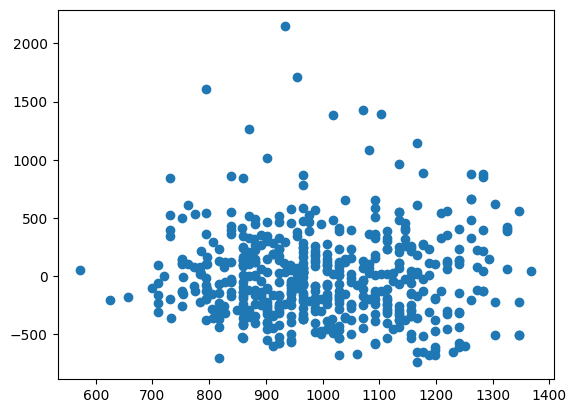

In [43]:
plt.scatter(fitbase,residbase)
plt.show()

In [46]:

lowess = sm.nonparametric.lowess

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# First plot (educ vs residuals)
mask1 = (
    ~regbase.resid.isna() & 
    ~train['educ'].isna() & 
    np.isfinite(regbase.resid) & 
    np.isfinite(train['educ'])
)
ax1.scatter(train['educ'], regbase.resid)
z1 = lowess(regbase.resid[mask1], train['educ'][mask1], frac=1./5)
ax1.plot(z1[:, 0], z1[:, 1], 'red')
ax1.set_xlabel('educ')
ax1.set_ylabel('Residuals')
ax1.axhline(color='Black', alpha=0.3, linestyle='--')

# Second plot (exper vs residuals)
mask2 = (
    ~regbase.resid.isna() & 
    ~train['exper'].isna() & 
    np.isfinite(regbase.resid) & 
    np.isfinite(train['exper'])
)
ax2.scatter(train['exper'], regbase.resid)
z2 = lowess(regbase.resid[mask2], train['exper'][mask2], frac=1./5)
ax2.plot(z2[:, 0], z2[:, 1], 'red')
ax2.set_xlabel('exper')
ax2.set_ylabel('Residuals')
ax2.axhline(color='Black', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

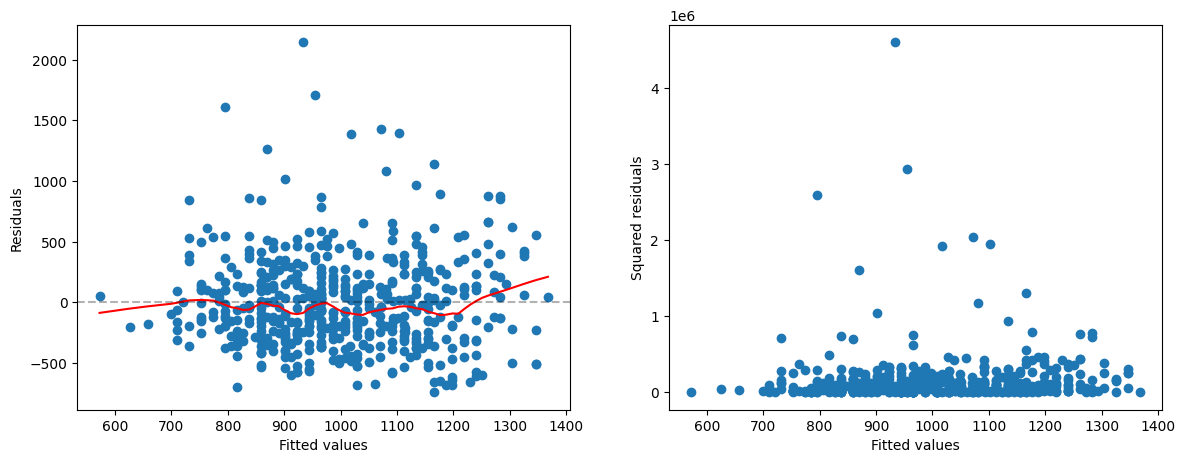

In [45]:
#Residual and squared residual plots against fitted values
fig = plt.figure(figsize=(14,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
ax1.scatter(regbase.fittedvalues,regbase.resid)
z1=lowess(regbase.resid,regbase.fittedvalues,frac=1./5)
ax1.plot(z1[:,0],z1[:,1],'red')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')
ax1.axhline(color='Black',alpha=0.3,linestyle='--')
residbase2=regbase.resid**2
ax2.scatter(regbase.fittedvalues,residbase2)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Squared residuals')
plt.show()

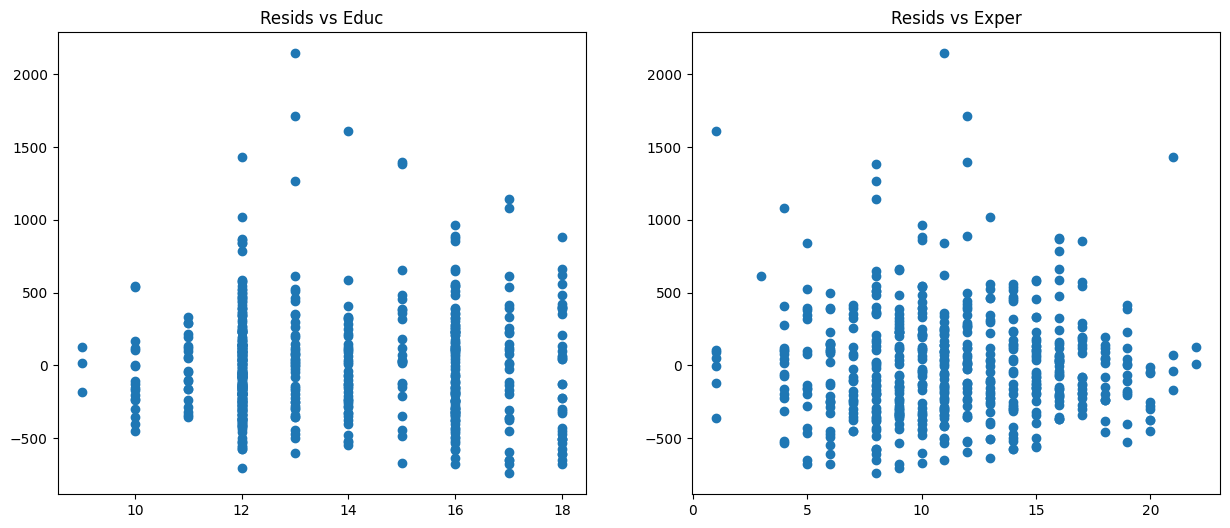

In [47]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(train['educ'],residbase)
ax1.set_title("Resids vs Educ")
ax2.scatter(train['exper'], residbase)
ax2.set_title("Resids vs Exper")
plt.show()

The residuals vs fitted values plot shows no clear pattern in the mean, i.e. the errors seem to average close to 0 for most fitted values, as confirmed by the LOESS curve (apart from a mild dip in the middle). The residuals vs each predictor show that **E**$(e|X) = 0$ appears to hold for most value of $X$. Thus, the linear model seems a reasonable fit for the wage data.

However, there is evidence that the variance of residuals increases slightly for higher fitted values. This is visible in the squared residuals plot, where spread is larger at the extremes. Hence, the assumption of constant variance may not hold, and inference may benefit from using heteroskedasticity-robust standard errors.

The scatter plots of wage against each predictor (in blue), overlaid with fitted values (in red), offer additional insights:

For **education**, the red predicted values track the increasing trend in wage with rising education, though they tend to underpredict for higher earners.

For **experience**, a similar pattern is observed: predictions follow the general shape of the data but fail to capture some curvature or variance at higher experience levels. These plots suggest that the model captures the main linear trend well, though it might benefit from polynomial or interaction terms for more accuracy. 

Regarding the other MLR LSA:

**LSA 2** requires **E**$(e|X) = 0$. While the residual plots support this assumption, it may still be violated due to **omitted variable bias**. For instance, IQ and KWW, which show a positive correlation with wage and likely correlate with educ, are not included in this model. This may bias the coefficient estimates for educ.

**LSA 3** assumes that the observations are i.i.d. As we lack temporal or cluster structure in the data, we proceed under this assumption.

**LSA 4** concerns finite $4^{th}$ moments. Variables such as exper, educ and wage are bounded in practice and show no severe outliers, so this assumption is reasonably satisfied. 

**LSA 5** (no perfect multicollinearity): educ and exper and only moderately correlated (~ -0.44), which is well below the threshold for concern. We tested this again using VIF, and the result cemented the previous argument. Hence, no standout multicollinearity issues are detected. 

# **Task 4: Variable and Model selection**

The variable KWW appears to be a likely determinant of an individual's wage. In addition, KWW has a moderate positive correlation with education ($r = 0.38$). This is intuitive, as individuals with higher levels of education are likely to score higher on knowledge-based assessments. Since KWW is both statistically significant in explaining wage ($p = 0.006$) and correlated with an included variable in the reduced model, its omission may be causing OVB to the education coefficient. I therefore add KWW to build a three variable MLR.

As a side note, the variables urban and married are also statistically significant ($p < 0.001$), and may explain wage differences due to regional wage premiums and household dynamics. However, they have relatively weak correlations with both educ and exper ($r < 0.09$), suggesting that their omission is less likely to introduce major bias in the current reduced model. 

In [73]:
newmodel = smf.ols(formula='wage ~ KWW + educ + exper + IQ + urban', data=train)
newreg = newmodel.fit()
newreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     30.46
Date:                Sun, 04 May 2025   Prob (F-statistic):           3.17e-27
Time:                        20:32:23   Log-Likelihood:                -3878.6
No. Observations:                 532   AIC:                             7769.
Df Residuals:                     526   BIC:                             7795.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -577.8519    151.232     -3.821      0.000    -874.945    -280.759
KWW            8.6465      2.417      3.578      0.000       3.899      13.394
educ          41.8066      9.671      4.323      0.000      22.808      60.805
exper         13.5987      4.119      3.302      0.001       5.508      21.690
IQ             3.8181      1.299      2.939      0.003       1.266       6.370
urban        188.0027     34.561      5.440      0.000     120.108     255.897
==============================================================================
Omnibus:                      160.728   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              654.852
Skew:                           1.317   Prob(JB):                    6.32e-143
Kurtosis:                       7.754   Cond. No.                     1.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

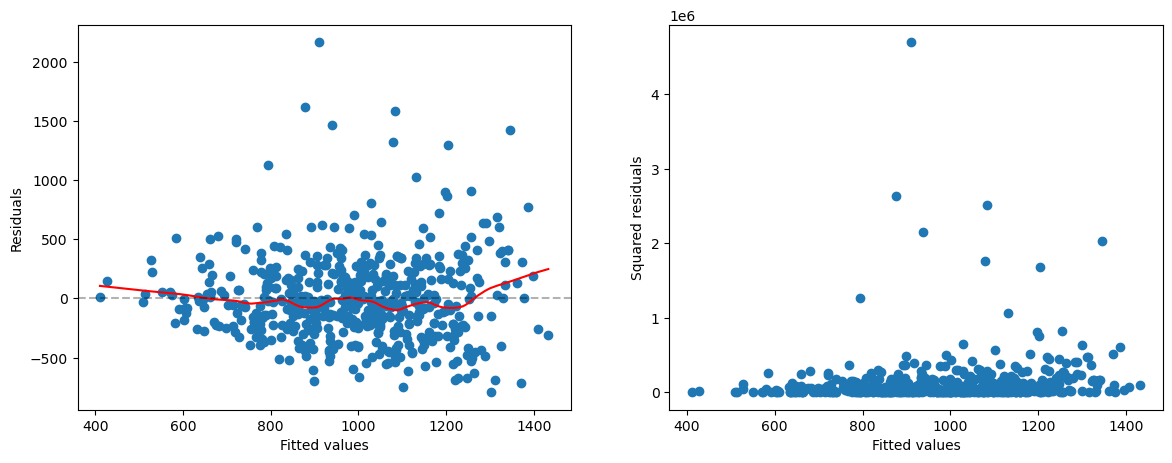

In [75]:
#Residual and squared residual plots against fitted values
fig = plt.figure(figsize=(14,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
ax1.scatter(newreg.fittedvalues,newreg.resid)
z1=lowess(newreg.resid,newreg.fittedvalues,frac=1./5)
ax1.plot(z1[:,0],z1[:,1],'red')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')
ax1.axhline(color='Black',alpha=0.3,linestyle='--')
newreg2=newreg.resid**2
ax2.scatter(newreg.fittedvalues,newreg2)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Squared residuals')
plt.show()

In [79]:
newresid=newreg.resid
newfit=newreg.fittedvalues
newreg.mse_resid**0.5

356.8662739217496

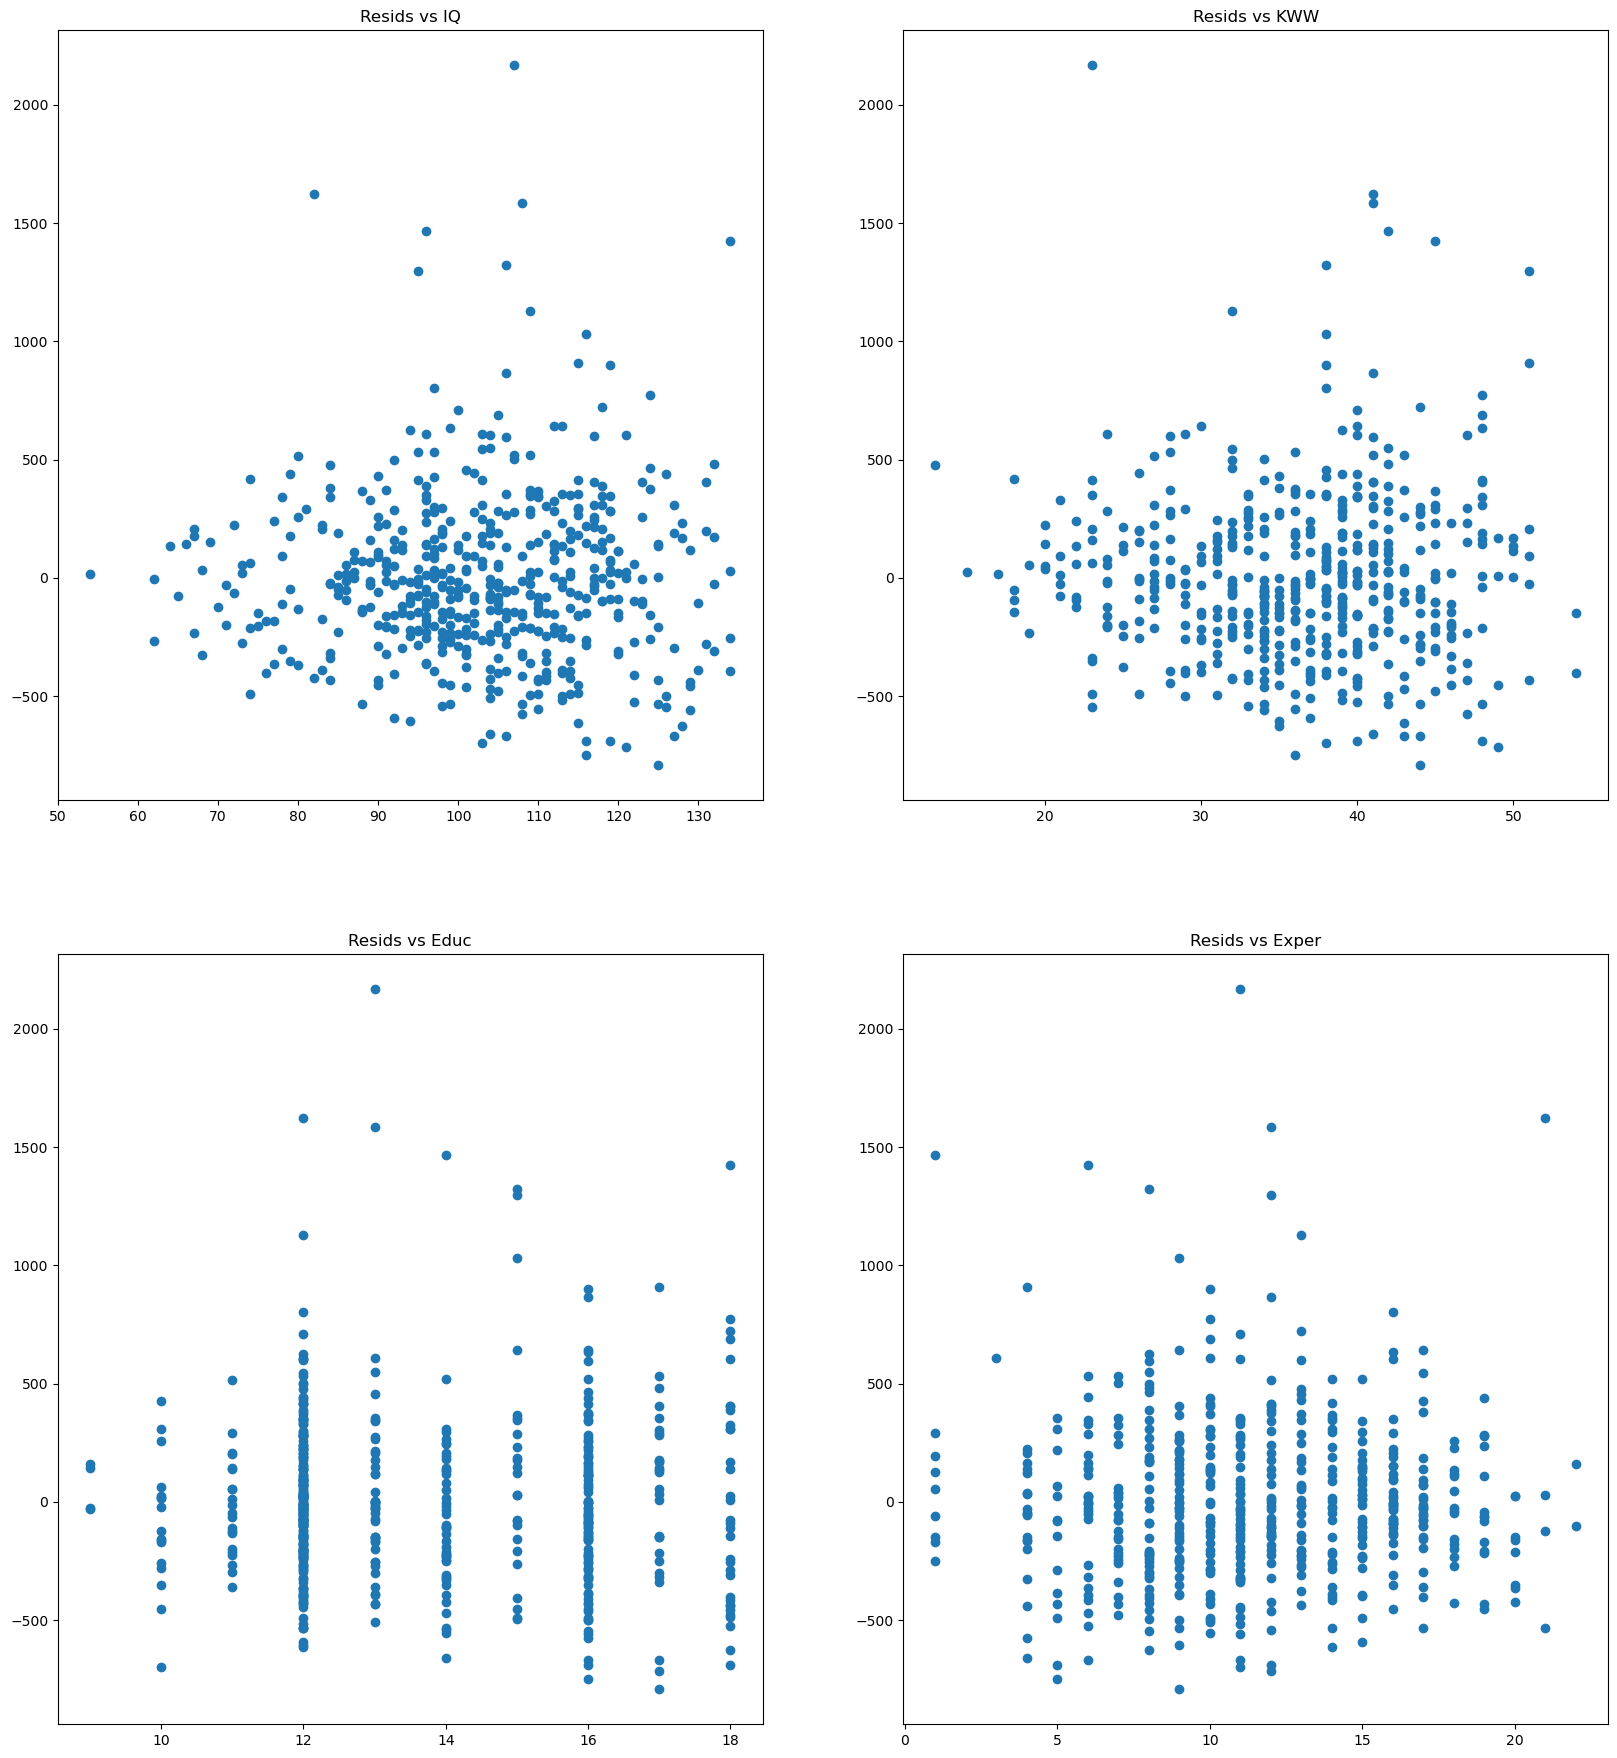

In [109]:
fig,ax=plt.subplots(2,2,figsize=(20,22))
ax[0,0].scatter(train['IQ'],newresid)
ax[0,0].set_title("Resids vs IQ")
ax[0,1].scatter(train['KWW'], newresid)
ax[0,1].set_title("Resids vs KWW")
ax[1,0].scatter(train['educ'],newresid)
ax[1,0].set_title("Resids vs Educ")
ax[1,1].scatter(train['exper'], newresid)
ax[1,1].set_title("Resids vs Exper")
plt.show()

In [89]:
#calculate VIFs for predictors
features=train[['educ','exper','IQ','KWW']]
features=sm.add_constant(features)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=[]
for i in range(1,features.shape[1]):
    vif_value=variance_inflation_factor(features.values,i)
    vif.append(vif_value)
    print(f"VIF for {features.columns[i]}: {vif_value:.3f}")
average_vif=sum(vif)/len(vif)
print(f"Average VIF: {average_vif:.3f}")

VIF for educ: 1.899
VIF for exper: 1.332
VIF for IQ: 1.499
VIF for KWW: 1.335
Average VIF: 1.516


The original reduced MLR was esimated as: $\hat{Wage} = -201.45 + 72.88 \times \mbox{educ} + 15.68 \times \mbox{exper}$. 95% confidence intervals for the two slopes are: $(58.65, 87.12)$ and $(8.65,22.71)$.

The new MLR is estimated as: $\hat{Wage} = -298.65 + 11.11 \times \mbox{KWW} + 54.23 \times \mbox{educ} + 11.32 \times \mbox{exper} $. 95% confidence intervals for the three slopes are: $(7.08,15.13), (38.72,69.75)$ and $(4.25,18.40)$.

The estimated effect of educ in the three variable MLR has dropped to be lower than the 95% CI from the two-variable MLR. Clearly, KWW was causing some OVB in this estimated effect in the two variable MLR.

The estimated effect of exper has become more negative, however the two 95% CIs have a large overlap and the difference in estimate here can probably be put down to simply estimation error, rather than OVB. In other words, though KWW could have caused some OVB in the two variable MLR for educ, the large standard error on this effect makes it difficult to assess the level of OVB caused, or even if any was apparent.

The variance inflation can be measured by the $R^2$ in the regression of one regressor on the other. Both equal to $\frac{1}{1-r^2}$, where $r$ is the correlation between two variables, as calculated above, equal around 1. This is not a large number -- the usual threshold for the presence of a multicollinearity problem is 5.

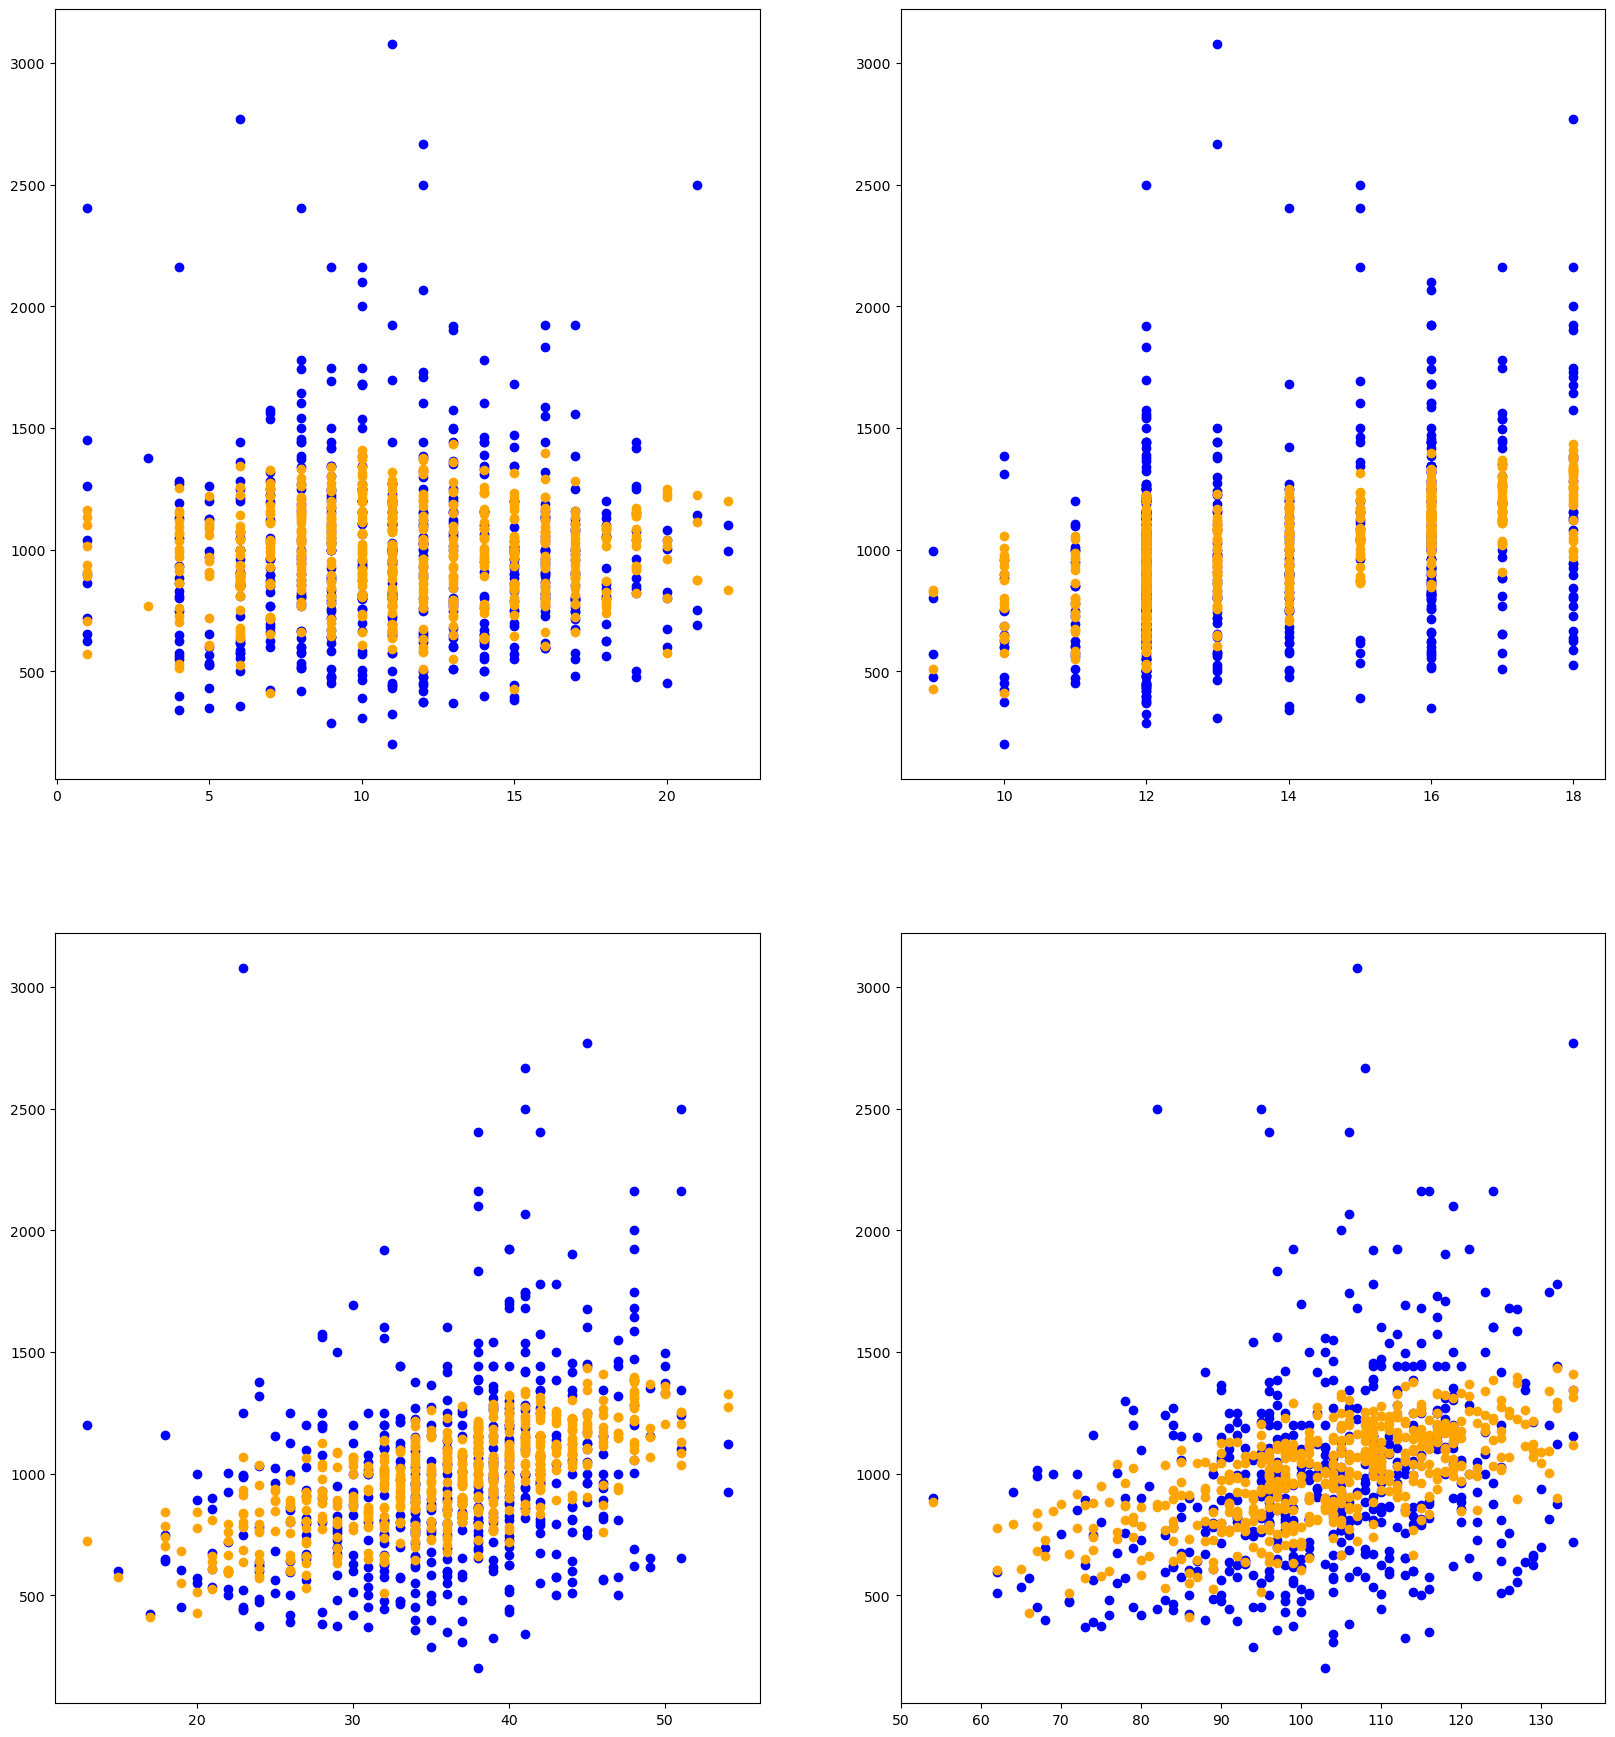

In [107]:
fig,ax=plt.subplots(2,2,figsize=(20,22))
ax[0,0].scatter(train['exper'], train['wage'], c='blue')
ax[0,0].scatter(train['exper'], newfit, c='orange')
ax[0,1].scatter(train['educ'], train['wage'], c='blue')
ax[0,1].scatter(train['educ'], newfit, c='orange')
ax[1,0].scatter(train['KWW'], train['wage'], c='blue')
ax[1,0].scatter(train['KWW'], newfit, c='orange')
ax[1,1].scatter(train['IQ'], train['wage'], c='blue')
ax[1,1].scatter(train['IQ'], newfit, c='orange')
plt.show()

In [113]:
#forward selection code
import statsmodels.formula.api as smf

def forward_selected(data, response, nominated = []):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model
#perform forward seledtion with 'wage' being the dependent variable
adj_wage_train=train.drop(columns=['lwage'])
model=forward_selected(adj_wage_train,response='wage',nominated=['educ','exper'])
model.summary()

you nominated variable(s) ['educ', 'exper'], the adj_r2 is: 0.132629
adding urban increases adj_r2 from 0.132629 to 0.180212
adding KWW increases adj_r2 from 0.180212 to 0.205806
adding married increases adj_r2 from 0.205806 to 0.222497
adding feduc increases adj_r2 from 0.222497 to 0.238261
adding south increases adj_r2 from 0.238261 to 0.246166
adding hours increases adj_r2 from 0.246166 to 0.250819
adding IQ increases adj_r2 from 0.250819 to 0.254830
adding black increases adj_r2 from 0.254830 to 0.256096
adding brthord increases adj_r2 from 0.256096 to 0.256133
final model is wage ~ educ + exper + urban + KWW + married + feduc + south + hours + IQ + black + brthord + 1, with adj_r2 of 0.256133


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     17.62
Date:                Sun, 04 May 2025   Prob (F-statistic):           7.36e-30
Time:                        21:10:19   Log-Likelihood:                -3862.0
No. Observations:                 532   AIC:                             7748.
Df Residuals:                     520   BIC:                             7799.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -376.8993    195.585     -1.927      0.055    -761.134       7.335
educ          39.5119      9.717      4.066      0.000      20.422      58.601
exper         12.3837      4.070      3.043      0.002       4.388      20.379
urban        178.5754     34.278      5.210      0.000     111.235     245.915
KWW            8.0227      2.407      3.333      0.001       3.295      12.751
married      184.3107     53.266      3.460      0.001      79.668     288.953
feduc         13.2922      5.433      2.447      0.015       2.620      23.965
south        -64.3891     33.910     -1.899      0.058    -131.006       2.228
hours         -4.6316      2.223     -2.084      0.038      -8.999      -0.265
IQ             2.0928      1.329      1.575      0.116      -0.518       4.704
black        -84.5822     62.751     -1.348      0.178    -207.860      38.695
brthord      -10.7167     10.583     -1.013      0.312     -31.507      10.073
==============================================================================
Omnibus:                      179.517   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              817.637
Skew:                           1.445   Prob(JB):                    2.83e-178
Kurtosis:                       8.342   Cond. No.                     1.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [117]:
#perform forward selection with 'lwage' being the dependent variable
adj_lwage_train=train.drop(columns=['wage'])
model=forward_selected(adj_lwage_train,response='lwage',nominated=['educ','exper'])
model.summary()

you nominated variable(s) ['educ', 'exper'], the adj_r2 is: 0.145605
adding urban increases adj_r2 from 0.145605 to 0.199011
adding KWW increases adj_r2 from 0.199011 to 0.225712
adding south increases adj_r2 from 0.225712 to 0.250012
adding married increases adj_r2 from 0.250012 to 0.270797
adding hours increases adj_r2 from 0.270797 to 0.285665
adding feduc increases adj_r2 from 0.285665 to 0.294159
adding IQ increases adj_r2 from 0.294159 to 0.299740
adding black increases adj_r2 from 0.299740 to 0.302390
adding meduc increases adj_r2 from 0.302390 to 0.303256
adding tenure increases adj_r2 from 0.303256 to 0.303921
final model is lwage ~ educ + exper + urban + KWW + south + married + hours + feduc + IQ + black + meduc + tenure + 1, with adj_r2 of 0.303921


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     20.32
Date:                Sun, 04 May 2025   Prob (F-statistic):           1.42e-36
Time:                        21:12:18   Log-Likelihood:                -167.10
No. Observations:                 532   AIC:                             360.2
Df Residuals:                     519   BIC:                             415.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4261      0.181     29.912      0.000       5.070       5.782
educ           0.0408      0.009      4.334      0.000       0.022       0.059
exper          0.0135      0.004      3.331      0.001       0.006       0.021
urban          0.1881      0.033      5.684      0.000       0.123       0.253
KWW            0.0076      0.002      3.215      0.001       0.003       0.012
south         -0.0997      0.033     -3.036      0.003      -0.164      -0.035
married        0.2040      0.051      3.966      0.000       0.103       0.305
hours         -0.0074      0.002     -3.429      0.001      -0.012      -0.003
feduc          0.0074      0.006      1.256      0.210      -0.004       0.019
IQ             0.0024      0.001      1.901      0.058   -8.17e-05       0.005
black         -0.0947      0.061     -1.559      0.120      -0.214       0.025
meduc          0.0085      0.007      1.301      0.194      -0.004       0.021
tenure         0.0038      0.003      1.224      0.222      -0.002       0.010
==============================================================================
Omnibus:                       16.012   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.435
Skew:                           0.015   Prob(JB):                     3.33e-08
Kurtosis:                       4.246   Cond. No.                     1.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The variable KWW is likely a determinant of wage, and is moderately correlated with educ. This makes sense: individuals with higher education levels tend to be more informed about the labor market. Since KWW was omitted in the previous model, it may have been causing OVB to the education coefficient. We now add it to construct a three variable MLR with KWW, educ and exper.

After including KWW, the residual vs fitted values plot shows that the errors are still centered around zero for most fitted values, and no strong non-linear pattern is observed. However, the variance of the residuals increases slightly with fitted values, suggesting heteroskedasticity. This is confirmed by the plot of squared residuals, which displays increasing spread. Therefore, a constant variance assumption may not be suitable, and robust standard errors should be used. 

The residuals vs each predictor show no strong patterns in the mean. In particular, residuals against KWW appear well-behaved. There is no evidence of non-linearity, though a slight U-shape in the lOWESS curve suggests that adding higher-order terms might improve the fit further. 

Regarding the other LSAs:

**LSA 2 E**$(\varepsilon | X)$ = 0 appears more likely to hold after including KWW, as the residuals show no systematic trend with any included predictor. 

**LSA 3** assumes i.i.d. data. We continue to assume this holds, as there is no time or group strcuture in the data.

**LSA 4** is about finite $4^{th}$ moments. All variables are bounded and show no extreme outliers in the plots; this assumption seems satisfied.

**LSA 5** requires no perfect multicollinearity. While KWW and educ are moderately correlated $(r = 0.38)$, this is well below any problematic level. Hence, multicollinearity does not appear to be a concern. 

**Model Selection** 

**Model 1**. Base linear with interaction term $KWW \times educ$ 


In [125]:

model1 = smf.ols(formula='wage ~ educ + exper + KWW + urban + IQ + KWW:educ', data=train) 
reg1 = model1.fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     26.12
Date:                Sun, 04 May 2025   Prob (F-statistic):           3.16e-27
Time:                        21:13:55   Log-Likelihood:                -3876.8
No. Observations:                 532   AIC:                             7768.
Df Residuals:                     525   BIC:                             7797.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    358.4097    513.393      0.698      0.485    -650.148    1366.968
educ         -31.7719     39.754     -0.799      0.425    -109.867      46.324
exper         13.3398      4.111      3.245      0.001       5.264      21.415
KWW          -16.6120     13.457     -1.234      0.218     -43.047       9.823
urban        193.2087     34.583      5.587      0.000     125.272     261.146
IQ             4.1092      1.305      3.149      0.002       1.546       6.673
KWW:educ       1.9003      0.996      1.908      0.057      -0.056       3.857
==============================================================================
Omnibus:                      160.902   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              669.695
Skew:                           1.311   Prob(JB):                    3.78e-146
Kurtosis:                       7.831   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
resid1=reg1.resid
fit1=reg1.fittedvalues
reg1.mse_resid ** 0.5

355.97405118062284

**Model 2** Base model with interaction terms of $KWW \times educ, IQ \times educ$

In [129]:

model2 = smf.ols(formula='wage ~ educ + exper + KWW + urban + IQ + KWW:educ + IQ:educ', data=train) 
reg2 = model2.fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     22.34
Date:                Sun, 04 May 2025   Prob (F-statistic):           1.70e-26
Time:                        21:14:36   Log-Likelihood:                -3876.8
No. Observations:                 532   AIC:                             7770.
Df Residuals:                     524   BIC:                             7804.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    344.0389    790.682      0.435      0.664   -1209.256    1897.334
educ         -30.6814     60.522     -0.507      0.612    -149.576      88.214
exper         13.3495      4.135      3.229      0.001       5.227      21.472
KWW          -16.7528     14.701     -1.140      0.255     -45.632      12.127
urban        193.1645     34.665      5.572      0.000     125.065     261.264
IQ             4.2932      7.802      0.550      0.582     -11.033      19.620
KWW:educ       1.9103      1.082      1.765      0.078      -0.215       4.036
IQ:educ       -0.0137      0.572     -0.024      0.981      -1.138       1.110
==============================================================================
Omnibus:                      160.909   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              669.531
Skew:                           1.311   Prob(JB):                    4.10e-146
Kurtosis:                       7.830   Cond. No.                     8.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [131]:
resid2=reg2.resid
fit2=reg2.fittedvalues
reg2.mse_resid ** 0.5

356.3133647284185

p-value too large that we cannot reject the null hypothesis 

**Model 3** Base model with interaction terms of $KWW \times educ, exper \times educ$

In [133]:
model3 = smf.ols(formula='wage ~ educ + exper + KWW + urban + IQ + KWW:educ + exper:educ', data=train) 
reg3 = model3.fit()
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     22.71
Date:                Sun, 04 May 2025   Prob (F-statistic):           6.60e-27
Time:                        21:15:09   Log-Likelihood:                -3875.8
No. Observations:                 532   AIC:                             7768.
Df Residuals:                     524   BIC:                             7802.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    742.3341    581.831      1.276      0.203    -400.674    1885.342
educ         -59.8074     44.494     -1.344      0.179    -147.216      27.601
exper        -20.3172     24.425     -0.832      0.406     -68.300      27.666
KWW          -17.1073     13.449     -1.272      0.204     -43.528       9.313
urban        193.3505     34.551      5.596      0.000     125.474     261.227
IQ             4.0405      1.305      3.097      0.002       1.478       6.603
KWW:educ       1.9363      0.995      1.945      0.052      -0.019       3.892
exper:educ     2.5728      1.840      1.398      0.163      -1.043       6.188
==============================================================================
Omnibus:                      163.097   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              688.142
Skew:                           1.325   Prob(JB):                    3.73e-150
Kurtosis:                       7.901   Cond. No.                     2.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [135]:
resid3=reg3.resid
fit3=reg3.fittedvalues
reg3.mse_resid ** 0.5

355.6510517148904

p-value too large that we cannot reject the null hypothesis 

**Model 4** Base model with interaction terms of $KWW \times educ$, forward selected $feduc$

In [144]:
model4 = smf.ols(formula='wage ~ educ + exper + KWW + urban + IQ + feduc', data=train) 
reg4 = model4.fit()
reg4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     27.24
Date:                Sun, 04 May 2025   Prob (F-statistic):           2.53e-28
Time:                        21:18:59   Log-Likelihood:                -3874.2
No. Observations:                 532   AIC:                             7762.
Df Residuals:                     525   BIC:                             7792.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -588.7478    150.156     -3.921      0.000    -883.728    -293.767
educ          35.6228      9.821      3.627      0.000      16.329      54.916
exper         14.7160      4.105      3.585      0.000       6.651      22.781
KWW            8.3224      2.401      3.466      0.001       3.605      13.040
urban        180.7941     34.390      5.257      0.000     113.235     248.354
IQ             3.1697      1.308      2.424      0.016       0.601       5.739
feduc         16.1219      5.410      2.980      0.003       5.494      26.750
==============================================================================
Omnibus:                      159.458   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              659.182
Skew:                           1.300   Prob(JB):                    7.25e-144
Kurtosis:                       7.793   Cond. No.                     1.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [146]:
resid4=reg4.resid
fit4=reg4.fittedvalues
reg4.mse_resid ** 0.5

354.22280281594453

**Model 5** Base model with forward selected $feduc$

In [140]:
model5 = smf.ols(formula='wage ~ educ + exper + KWW + urban + IQ + feduc + KWW:educ', data=train) 
reg5 = model5.fit()
reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     24.02
Date:                Sun, 04 May 2025   Prob (F-statistic):           2.20e-28
Time:                        21:18:07   Log-Likelihood:                -3872.2
No. Observations:                 532   AIC:                             7760.
Df Residuals:                     524   BIC:                             7795.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    362.2028    509.506      0.711      0.477    -638.723    1363.129
educ         -39.1565     39.529     -0.991      0.322    -116.811      38.498
exper         14.4604      4.096      3.530      0.000       6.413      22.508
KWW          -17.3365     13.357     -1.298      0.195     -43.576       8.903
urban        186.0347     34.403      5.407      0.000     118.449     253.620
IQ             3.4611      1.313      2.636      0.009       0.882       6.040
feduc         16.2281      5.396      3.007      0.003       5.628      26.828
KWW:educ       1.9302      0.989      1.953      0.051      -0.012       3.872
==============================================================================
Omnibus:                      159.696   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              676.219
Skew:                           1.294   Prob(JB):                    1.45e-147
Kurtosis:                       7.880   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [148]:
resid5=reg5.resid
fit5=reg5.fittedvalues
reg5.mse_resid ** 0.5

353.27765046325834

In [156]:
model6 = smf.ols(formula='lwage ~ educ + exper + KWW + urban + IQ ', data=train) 
reg6 = model6.fit()
reg6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     34.72
Date:                Sun, 04 May 2025   Prob (F-statistic):           1.08e-30
Time:                        21:20:23   Log-Likelihood:                -193.69
No. Observations:                 532   AIC:                             399.4
Df Residuals:                     526   BIC:                             425.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1398      0.148     34.631      0.000       4.848       5.431
educ           0.0427      0.009      4.500      0.000       0.024       0.061
exper          0.0170      0.004      4.202      0.000       0.009       0.025
KWW            0.0086      0.002      3.629      0.000       0.004       0.013
urban          0.1985      0.034      5.853      0.000       0.132       0.265
IQ             0.0043      0.001      3.408      0.001       0.002       0.007
==============================================================================
Omnibus:                       15.211   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.931
Skew:                          -0.231   Prob(JB):                     1.05e-05
Kurtosis:                       3.906   Cond. No.                     1.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [158]:
resid6=reg6.resid
fit6=reg6.fittedvalues
reg6.mse_resid ** 0.5

0.3502195634647707

In [160]:
model7 = smf.ols(formula='lwage ~ educ + exper + KWW + urban + IQ + feduc + married', data=train) 
reg7 = model7.fit()
reg7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     29.02
Date:                Sun, 04 May 2025   Prob (F-statistic):           7.55e-34
Time:                        21:21:06   Log-Likelihood:                -182.40
No. Observations:                 532   AIC:                             380.8
Df Residuals:                     524   BIC:                             415.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9510      0.153     32.459      0.000       4.651       5.251
educ           0.0397      0.010      4.155      0.000       0.021       0.058
exper          0.0172      0.004      4.302      0.000       0.009       0.025
KWW            0.0078      0.002      3.345      0.001       0.003       0.012
urban          0.1932      0.033      5.793      0.000       0.128       0.259
IQ             0.0037      0.001      2.878      0.004       0.001       0.006
feduc          0.0140      0.005      2.676      0.008       0.004       0.024
married        0.2068      0.052      3.950      0.000       0.104       0.310
==============================================================================
Omnibus:                       19.080   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.235
Skew:                          -0.250   Prob(JB):                     1.00e-07
Kurtosis:                       4.098   Cond. No.                     1.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [162]:
resid7=reg7.resid
fit7=reg7.fittedvalues
reg7.mse_resid ** 0.5

0.34352425279319704

In [166]:
model8 = smf.ols(formula='lwage ~ educ + exper + KWW + urban + IQ + feduc + married + KWW:educ', data=train) 
reg8 = model8.fit()
reg8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     25.55
Date:                Sun, 04 May 2025   Prob (F-statistic):           2.41e-33
Time:                        21:22:08   Log-Likelihood:                -181.82
No. Observations:                 532   AIC:                             381.6
Df Residuals:                     523   BIC:                             420.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4594      0.496     11.003      0.000       4.485       6.434
educ          -0.0004      0.038     -0.012      0.991      -0.076       0.075
exper          0.0170      0.004      4.264      0.000       0.009       0.025
KWW           -0.0060      0.013     -0.459      0.646      -0.032       0.020
urban          0.1960      0.033      5.861      0.000       0.130       0.262
IQ             0.0038      0.001      2.982      0.003       0.001       0.006
feduc          0.0141      0.005      2.687      0.007       0.004       0.024
married        0.2088      0.052      3.987      0.000       0.106       0.312
KWW:educ       0.0010      0.001      1.077      0.282      -0.001       0.003
==============================================================================
Omnibus:                       19.182   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.791
Skew:                          -0.247   Prob(JB):                     7.58e-08
Kurtosis:                       4.112   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [168]:
resid8=reg8.resid
fit8=reg8.fittedvalues
reg8.mse_resid ** 0.5

0.34347194898579886

In [170]:
train['leduc']=np.log(train['educ'])
model9=smf.ols(formula='lwage ~ leduc + exper + IQ + KWW + urban',data=train)
reg9=model9.fit()
reg9.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     35.00
Date:                Sun, 04 May 2025   Prob (F-statistic):           6.39e-31
Time:                        21:24:04   Log-Likelihood:                -193.15
No. Observations:                 532   AIC:                             398.3
Df Residuals:                     526   BIC:                             424.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1403      0.312     13.288      0.000       3.528       4.752
leduc          0.6115      0.132      4.620      0.000       0.352       0.872
exper          0.0174      0.004      4.286      0.000       0.009       0.025
IQ             0.0043      0.001      3.345      0.001       0.002       0.007
KWW            0.0085      0.002      3.583      0.000       0.004       0.013
urban          0.1977      0.034      5.833      0.000       0.131       0.264
==============================================================================
Omnibus:                       14.484   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.301
Skew:                          -0.228   Prob(JB):                     2.37e-05
Kurtosis:                       3.868   Cond. No.                     2.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [182]:
#SER of model 9
reg9.mse_resid**0.5

0.34986694808851243

In [178]:
#SER of original scale
original_scale_predictions_9=np.exp(reg9.fittedvalues)
original_residuals_9=train['wage']-original_scale_predictions_9
n=len(train['wage'])
p=reg9.df_model
ser_original_scale_9=np.sqrt(np.sum(original_residuals_9**2)/(n-p-1))
print(ser_original_scale_9)

360.9655644022529


In [180]:

model10=smf.ols(formula='lwage ~ leduc + exper + IQ + KWW + urban + feduc + married',data=train)
reg10=model10.fit()
reg10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     29.21
Date:                Sun, 04 May 2025   Prob (F-statistic):           4.73e-34
Time:                        21:27:18   Log-Likelihood:                -181.92
No. Observations:                 532   AIC:                             379.8
Df Residuals:                     524   BIC:                             414.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0199      0.314     12.788      0.000       3.402       4.637
leduc          0.5694      0.133      4.273      0.000       0.308       0.831
exper          0.0175      0.004      4.378      0.000       0.010       0.025
IQ             0.0036      0.001      2.827      0.005       0.001       0.006
KWW            0.0077      0.002      3.301      0.001       0.003       0.012
urban          0.1926      0.033      5.778      0.000       0.127       0.258
feduc          0.0138      0.005      2.628      0.009       0.003       0.024
married        0.2076      0.052      3.968      0.000       0.105       0.310
==============================================================================
Omnibus:                       18.387   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.403
Skew:                          -0.247   Prob(JB):                     2.50e-07
Kurtosis:                       4.062   Cond. No.                     2.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [184]:
#SER of model 10
reg10.mse_resid**0.5

0.34321005857174003

In [186]:
#SER of original scale
original_scale_predictions_10=np.exp(reg10.fittedvalues)
original_residuals_10=train['wage']-original_scale_predictions_10
n=len(train['wage'])
p=reg10.df_model
ser_original_scale_10=np.sqrt(np.sum(original_residuals_10**2)/(n-p-1))
print(ser_original_scale_10)

353.6018638818806
